In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# NLP From Scratch: 通过character级别的RNN对于名字分类
**Author**: [Sean Robertson](https://github.com/spro)

我们将构建并训练一个基本的字符级循环神经网络（RNN），用于对单词进行分类。本教程连同另外两个“从零开始”的自然语言处理（NLP）教程：:doc:/intermediate/char_rnn_generation_tutorial 和 :doc:/intermediate/seq2seq_translation_tutorial，展示了如何预处理数据以建模NLP。特别是这些教程没有使用 torchtext 的许多便利功能，因此您可以看到在较低层面上对NLP进行建模的预处理是如何工作的。

字符级RNN将单词视为一系列字符 - 在每个步骤中输出预测和“隐藏状态”，将其前一个隐藏状态输入到下一个步骤中。我们将最后的预测作为输出，即单词属于哪个类别。

具体来说，我们将在来自18种语言的几千个姓氏上进行训练，并根据拼写预测一个名字来自哪种语言：

```sh
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```
## 准备工作

在开始本教程之前，建议您已经安装了 PyTorch，并且对 Python 编程语言和张量有基本的了解：

https://pytorch.org/ 用于安装说明
:doc:`/beginner/deep_learning_60min_blitz` 用于开始使用 PyTorch 并了解张量的基础知识
:doc:`/beginner/pytorch_with_examples` 提供了广泛而深入的概述
:doc:`/beginner/former_torchies_tutorial` 如果您之前是 Lua Torch 用户
了解 RNN 及其工作原理也会很有帮助：

循环神经网络的不合理有效性 展示了许多现实生活中的例子
理解 LSTM 网络 专门讲述了 LSTM，但也对 RNN 有一般性的介绍

## 准备数据

<div class="alert alert-info"><h4>Note</h4><p>Download the data from
   [here](https://download.pytorch.org/tutorial/data.zip)
   and extract it to the current directory.</p></div>

包含在 data/names 目录中的是 18 个以 [语言].txt 命名的文本文件。每个文件包含一堆名字，每行一个名字，大多数是罗马化的（但我们仍然需要从 Unicode 转换为 ASCII）。

我们最终将得到一个按语言分类的名字列表的字典，{language: [names ...]}。用于后续扩展性的通用变量“category”和“line”（在我们的案例中分别用于语言和名字）。


In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('../../data/nlp_scratch/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../../data/nlp_scratch/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['../../data/nlp_scratch/names/Dutch.txt', '../../data/nlp_scratch/names/Russian.txt', '../../data/nlp_scratch/names/Scottish.txt', '../../data/nlp_scratch/names/Arabic.txt', '../../data/nlp_scratch/names/Vietnamese.txt', '../../data/nlp_scratch/names/German.txt', '../../data/nlp_scratch/names/Chinese.txt', '../../data/nlp_scratch/names/Italian.txt', '../../data/nlp_scratch/names/Polish.txt', '../../data/nlp_scratch/names/English.txt', '../../data/nlp_scratch/names/Czech.txt', '../../data/nlp_scratch/names/Korean.txt', '../../data/nlp_scratch/names/Irish.txt', '../../data/nlp_scratch/names/Spanish.txt', '../../data/nlp_scratch/names/Japanese.txt', '../../data/nlp_scratch/names/Portuguese.txt', '../../data/nlp_scratch/names/French.txt', '../../data/nlp_scratch/names/Greek.txt']
Slusarski


现在我们有了 category_lines，这是一个字典，将每个类别（语言）映射到一系列行（名字）。我们还跟踪了 all_categories（仅仅是语言列表）和 n_categories 以供后续参考。

In [4]:
print(category_lines['Chinese'][:5])

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']


### 将名字转换为张量

现在我们已经组织好所有名字，我们需要将它们转换为张量以便使用。

为了表示一个单个字母，我们使用大小为 ``<1 x n_letters>`` 的“单热向量”。单热向量除了当前字母的索引位置是 1 以外，其他都填充为 0，例如：``"b" = <0 1 0 0 0 ...>``。

为了形成一个单词，我们将一系列这样的向量连接成一个 2D 矩阵 ``<line_length x 1 x n_letters>``。

这个额外的 1 维是因为 PyTorch 假设所有内容都是批处理的 - 我们在这里仅使用批量大小为 1。


In [5]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## 创建网络

在 autograd 出现之前，通过 Torch 创建循环神经网络涉及到在多个时间步上克隆一层的参数。这些层持有隐藏状态和梯度，现在这些全部由图本身处理。这意味着你可以以一种非常“纯净”的方式实现 RNN，就像常规的前馈层一样。

这个 RNN 模块（大部分复制自 [PyTorch for Torch users 教程](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net)）仅仅是两个线性层，它们作用于输入和隐藏状态，输出后有一个 ``LogSoftmax`` 层。


In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

要运行这个网络的一个步骤，我们需要传递一个输入（在我们的案例中，是当前字母的张量）和一个先前的隐藏状态（我们最初将其初始化为零）。我们将得到输出（每种语言的概率）和下一个隐藏状态（我们将其保留到下一步）。

In [9]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)  # RNN


为了提高效率，我们不想为每个步骤创建一个新的张量，所以我们将使用 ``lineToTensor`` 而不是 ``letterToTensor`` 并使用切片。这可以通过预先计算张量的批次来进一步优化。

In [10]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8847, -2.9724, -2.9377, -2.8832, -2.8561, -2.9621, -2.9515, -2.9514,
         -2.8419, -2.9018, -2.8724, -2.9023, -2.8927, -2.8000, -2.8410, -2.8354,
         -2.8906, -2.8692]], grad_fn=<LogSoftmaxBackward0>)


正如您所看到的，输出是一个 ``<1 x n_categories>`` 张量，其中每个项目是该类别的可能性（数值越高，越可能）。


## 训练
训练准备
------

在进入训练之前，我们应该制作一些辅助函数。第一个是解释网络的输出，我们知道这是每个类别的可能性。我们可以使用 ``Tensor.topk`` 来获取最大值的索引：

In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 13)


我们还想要一种快速获得训练示例（一个名字及其语言）的方法：

In [12]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Kogara
category = Dutch / line = Hout
category = Greek / line = Eatros
category = Portuguese / line = Souza
category = Czech / line = Cerney
category = Vietnamese / line = Bui
category = Russian / line = Rahalsky
category = Japanese / line = Komiya
category = Greek / line = Kaloxylos
category = Spanish / line = Alvarez


### 训练网络

现在要训练这个网络，只需要向它展示一系列的例子，让它进行猜测，并告诉它猜错了。

对于损失函数，``nn.NLLLoss`` 是合适的，因为 RNN 的最后一层是 ``nn.LogSoftmax``。


In [13]:
criterion = nn.NLLLoss()

训练的每个循环将：

- 创建输入和目标张量
- 创建一个归零的初始隐藏状态
- 读取每个字母并

   - 为下一个字母保留隐藏状态

- 将最终输出与目标进行比较
- 反向传播
- 返回输出和损失

In [14]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

现在我们只需要用一系列例子来运行它。由于 ``train`` 函数返回输出和损失，我们可以打印它的猜测，并跟踪损失以便绘图。由于有成千上万的例子，我们只在每 ``print_every`` 个例子打印一次，并取损失的平均值。

In [15]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 2.0087 Danas / Greek ✓
10000 10% (0m 4s) 1.3420 Noguchi / Japanese ✓
15000 15% (0m 6s) 1.4899 Jiu / Korean ✗ (Chinese)
20000 20% (0m 9s) 1.4918 Ly / Korean ✗ (Vietnamese)
25000 25% (0m 11s) 2.7963 Lama / Japanese ✗ (Italian)
30000 30% (0m 13s) 1.2887 Vilaro / Italian ✗ (Spanish)
35000 35% (0m 15s) 0.3873 Dubicki / Polish ✓
40000 40% (0m 18s) 1.9999 Cham / Vietnamese ✗ (Arabic)
45000 45% (0m 20s) 1.3134 Tang / Vietnamese ✗ (Chinese)
50000 50% (0m 22s) 1.2417 Colbert / Dutch ✗ (French)
55000 55% (0m 24s) 0.2476 Malinowski / Polish ✓
60000 60% (0m 27s) 0.5098 Benesch / Czech ✓
65000 65% (0m 29s) 1.3273 Maria / Portuguese ✓
70000 70% (0m 31s) 0.2257 O'Donoghue / Irish ✓
75000 75% (0m 33s) 2.6236 Mas / Chinese ✗ (Spanish)
80000 80% (0m 36s) 0.8637 Souza / Portuguese ✓
85000 85% (0m 38s) 1.5951 Koury / English ✗ (Arabic)
90000 90% (0m 40s) 0.5871 Mazuka / Japanese ✓
95000 95% (0m 42s) 0.4386 Si / Korean ✓
100000 100% (0m 45s) 0.3392 Pham / Vietnamese ✓


### 绘制结果

Plotting the historical loss from ``all_losses`` shows the network
learning:




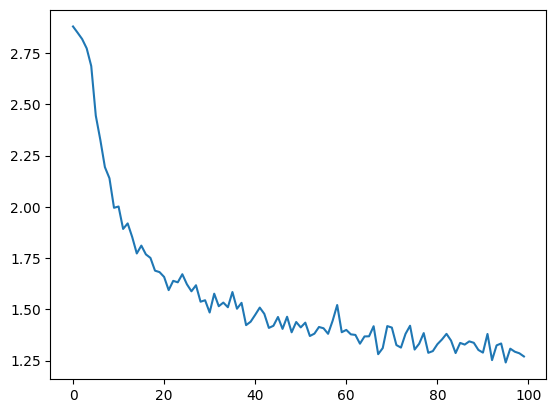

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## 评估结果

为了看到网络在不同类别上的表现如何，我们将创建一个混淆矩阵，表示每种实际语言（行）网络猜测的语言（列）。为了计算混淆矩阵，需要通过网络运行一系列样本，使用 ``evaluate()`` 函数，这与 ``train()`` 函数相同，只是没有反向传播。

/tmp/ipykernel_18756/3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_18756/3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


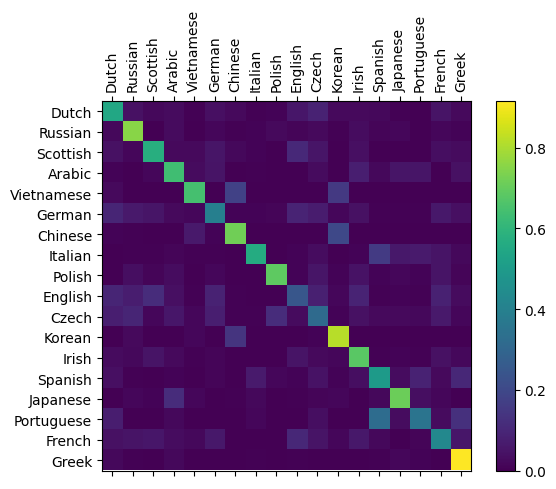

In [17]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

您可以在主轴外挑选出亮点，这些亮点显示了它错误猜测的语言，例如把韩语猜测为中文，把意大利语猜测为西班牙语。看起来它对希腊语表现非常好，但对英语表现非常差（可能是因为与其他语言的重叠）。

### Running on User Input




In [18]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Liu')


> Dovesky
(-0.40) Russian
(-1.22) Czech
(-3.81) English

> Jackson
(-0.51) Scottish
(-1.78) Russian
(-2.22) English

> Satoshi
(-0.61) Japanese
(-1.54) Italian
(-2.68) Arabic

> Liu
(-0.51) Chinese
(-1.14) Vietnamese
(-3.04) Korean


[实用 PyTorch 仓库(deprecated in 2021)](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification)中的最终脚本版本将上述代码分为几个文件：

-  ``data.py``（加载文件）
-  ``model.py``（定义 RNN）
-  ``train.py``（运行训练）
-  ``predict.py``（使用命令行参数运行 ``predict()``）
-  ``server.py``（使用 ``bottle.py`` 以 JSON API 形式提供预测）

运行 ``train.py`` 以训练并保存网络。

运行 ``predict.py`` 并输入一个名称来查看预测：
```sh
$ python predict.py Hazaki
(-0.42) Japanese
(-1.39) Polish
(-3.51) Czech
```
运行 ``server.py`` 并访问 http://localhost:5533/Yourname 来获取预测的 JSON 输出。



## Exercises

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


